In [1]:
#tensorflow homework 3

import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization

In [6]:
SHUFFLE_BUFFER_SIZE = 1000
BATCH_SIZE = 64
NUM_EPOCHS = 10
LEARNING_RATE = 0.001


Training batch size: 64
Each image size: (32, 32, 3)
Sample labels from Training set: [2 9 3 0 7]
Test batch size: 64
Each image size: (32, 32, 3)
Sample labels from Test set: [7 0 6 9 5]


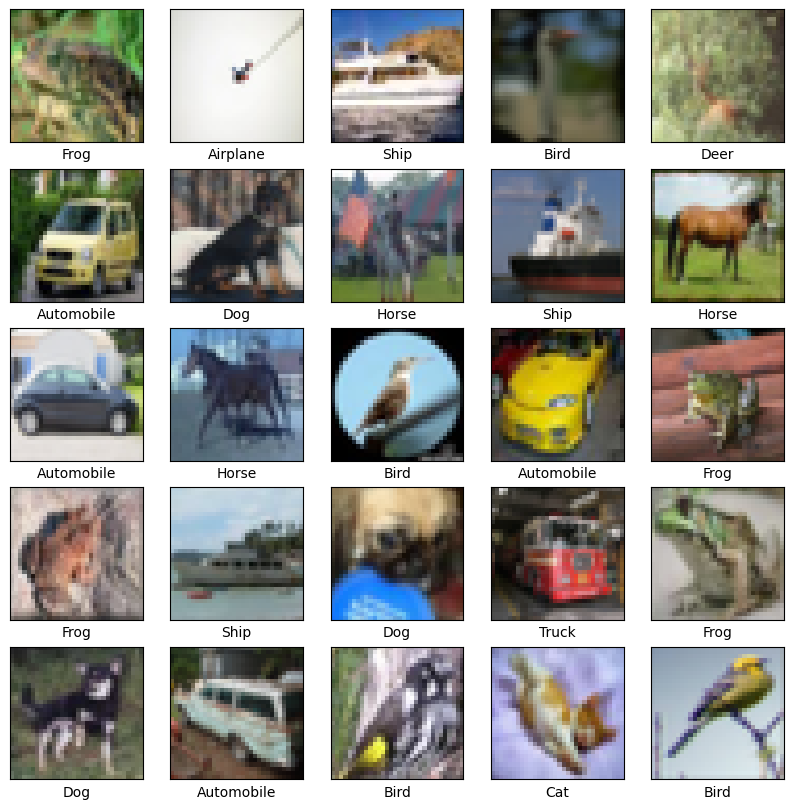

Epoch 1: Loss: 1.9220900535583496, Accuracy: 0.28661999106407166
Epoch 2: Loss: 1.7218743562698364, Accuracy: 0.3708600103855133
Epoch 3: Loss: 1.6263432502746582, Accuracy: 0.4111799895763397
Epoch 4: Loss: 1.5564640760421753, Accuracy: 0.4364199936389923
Epoch 5: Loss: 1.494753360748291, Accuracy: 0.46000000834465027
Epoch 6: Loss: 1.4452102184295654, Accuracy: 0.4788999855518341
Epoch 7: Loss: 1.4011118412017822, Accuracy: 0.498199999332428
Epoch 8: Loss: 1.3608731031417847, Accuracy: 0.5146600008010864
Epoch 9: Loss: 1.3259621858596802, Accuracy: 0.5267000198364258
Epoch 10: Loss: 1.2920819520950317, Accuracy: 0.539139986038208
Test accuracy: 0.542900025844574
157/157 [==============================] - 1s 5ms/step - loss: 1.2767 - accuracy: 0.5429
Test accuracy: 0.542900025844574
Test loss: 1.2767307758331299


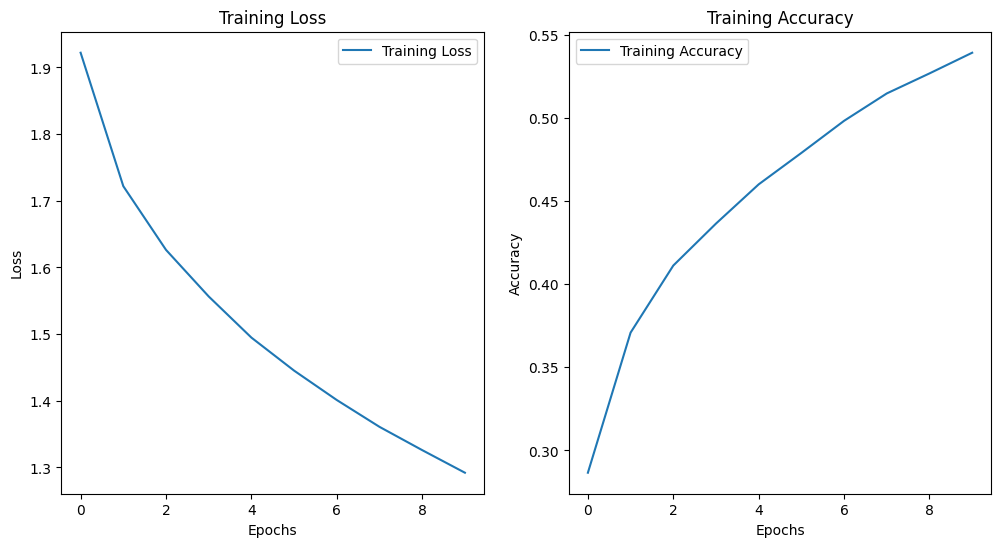

In [8]:
# 4rd this is it
# 1.1 Prepare the Dataset

def load_and_prep_cifar(batch_size, shuffle_buffer_size):
    def preprocessing_func(img, label):
        img = tf.cast(img, tf.float32)
        img = (img / 255.0)  # Normalize between 0 and 1
        return img, label

    train = tfds.load('cifar10', split='train', as_supervised=True)
    test = tfds.load('cifar10', split='test', as_supervised=True)

    train = train.map(preprocessing_func, num_parallel_calls=tf.data.AUTOTUNE)
    test = test.map(preprocessing_func, num_parallel_calls=tf.data.AUTOTUNE)

    train = train.shuffle(shuffle_buffer_size).batch(batch_size).prefetch(tf.data.AUTOTUNE)
    test = test.batch(batch_size).prefetch(tf.data.AUTOTUNE)

    return train, test

def get_familiar_with_data(dataset, name):
    for images, labels in dataset.take(1):
        print(f"{name} batch size:", images.shape[0])
        print("Each image size:", images.shape[1:])
        sample_labels = labels.numpy()
        print(f"Sample labels from {name} set:", sample_labels[:5] if sample_labels.ndim > 0 else sample_labels)

def visualize_data(dataset):
    class_names = ['Airplane', 'Automobile', 'Bird', 'Cat', 'Deer',
                   'Dog', 'Frog', 'Horse', 'Ship', 'Truck']

    plt.figure(figsize=(10, 10))
    for images, labels in dataset.take(1):
        num_images = min(images.shape[0], 25)

        for i in range(num_images):
            plt.subplot(5, 5, i + 1)
            plt.xticks([])
            plt.yticks([])
            plt.grid(False)
            plt.imshow(images[i], cmap=plt.cm.binary)
            plt.xlabel(class_names[labels[i].numpy()])

    plt.show()

train_dataset, test_dataset = load_and_prep_cifar(batch_size=BATCH_SIZE, shuffle_buffer_size=SHUFFLE_BUFFER_SIZE)
get_familiar_with_data(train_dataset, "Training")
get_familiar_with_data(test_dataset, "Test")
visualize_data(train_dataset)



def create_my_cifar_cnn(name='my_cnn', num_filters=[5, 10, 64], kernel_size=3, dense_units=10):
    inputs = tf.keras.Input(shape=(32, 32, 3), dtype=tf.float32)

    x = inputs
    for filters in num_filters:
        x = tf.keras.layers.Conv2D(filters=filters, kernel_size=kernel_size, activation='relu', padding='same')(x)
        x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)

    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dense(dense_units, activation='softmax')(x)

    model = tf.keras.Model(inputs, x, name=name)
    return model


def create_optimized_cifar_cnn(name='optimized_cnn', num_filters=[32, 64, 128], kernel_size=3, dense_units=128):
    inputs = tf.keras.Input(shape=(32, 32, 3), dtype=tf.float32)

    x = inputs
    for filters in num_filters:
        x = tf.keras.layers.Conv2D(filters=filters, kernel_size=kernel_size, activation='relu', padding='same')(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
        x = tf.keras.layers.Dropout(0.25)(x)

    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dense(dense_units, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    x = tf.keras.layers.Dense(10, activation='softmax')(x)  # CIFAR-10 has 10 classes

    model = tf.keras.Model(inputs, x, name=name)
    return model


'''
def train(num_epochs, batch_size, shuffle_buffer_size, lr):
    model = create_my_cifar_cnn()
    train_dataset, test_dataset = load_and_prep_cifar(batch_size=batch_size, shuffle_buffer_size=shuffle_buffer_size)
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
    loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
    train_loss_results = []
    train_accuracy_results = []
    for epoch in range(num_epochs):
        epoch_loss_avg = tf.keras.metrics.Mean()
        epoch_accuracy = tf.keras.metrics.SparseCategoricalAccuracy()
        # Training loop - using batches of 32
        for x, y in train_dataset:
            with tf.GradientTape() as tape:
                predictions = model(x, training=True)
                loss = loss_fn(y, predictions)
            gradients = tape.gradient(loss, model.trainable_variables)
            optimizer.apply_gradients(zip(gradients, model.trainable_variables))

            # Track progress
            epoch_loss_avg.update_state(loss)  # Add current batch loss
            # Compare predicted label to actual label
            epoch_accuracy.update_state(y, predictions)

        # End epoch
        train_loss_results.append(epoch_loss_avg.result())
        train_accuracy_results.append(epoch_accuracy.result())

        print(f"Epoch {epoch+1}: Loss: {epoch_loss_avg.result()}, Accuracy: {epoch_accuracy.result()}")

    return model, train_loss_results, train_accuracy_results

'''


def train(num_epochs, batch_size, shuffle_buffer_size, lr, model_fn=create_my_cifar_cnn):
    # Create model using the provided model function
    model = model_fn()

    # Compile the model
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  metrics=['accuracy'])

    # Prepare the data
    train_dataset, test_dataset = load_and_prep_cifar(batch_size, shuffle_buffer_size)

    # Training loop
    train_loss_results = []
    train_accuracy_results = []
    for epoch in range(num_epochs):
        epoch_loss_avg = tf.keras.metrics.Mean()
        epoch_accuracy = tf.keras.metrics.SparseCategoricalAccuracy()
        for x, y in train_dataset:
            with tf.GradientTape() as tape:
                predictions = model(x, training=True)
                loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)(y, predictions)
            gradients = tape.gradient(loss, model.trainable_variables)
            model.optimizer.apply_gradients(zip(gradients, model.trainable_variables))

            epoch_loss_avg.update_state(loss)
            epoch_accuracy.update_state(y, predictions)

        train_loss_results.append(epoch_loss_avg.result())
        train_accuracy_results.append(epoch_accuracy.result())
        print(f"Epoch {epoch+1}: Loss: {epoch_loss_avg.result()}, Accuracy: {epoch_accuracy.result()}")

    return model, train_loss_results, train_accuracy_results, test_dataset


def evaluate(model, test_dataset):
    test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy()

    for x, y in test_dataset:
        predictions = model(x, training=False)
        test_accuracy.update_state(y, predictions)

    print(f"Test accuracy: {test_accuracy.result()}")


def visualize_performance(train_loss, train_accuracy, model, test_dataset):
    # Calculate test loss and accuracy
    test_loss, test_accuracy = model.evaluate(test_dataset)

    # Plot training loss and accuracy
    epochs_range = range(len(train_loss))
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, train_loss, label='Training Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, train_accuracy, label='Training Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training Accuracy')
    plt.legend()

    # Print and visualize test accuracy
    print(f"Test accuracy: {test_accuracy}")
    print(f"Test loss: {test_loss}")

    plt.show()




model, train_loss, train_accuracy, test_dataset = train(NUM_EPOCHS, BATCH_SIZE, SHUFFLE_BUFFER_SIZE, LEARNING_RATE)
evaluate(model, test_dataset)
visualize_performance(train_loss, train_accuracy, model, test_dataset)


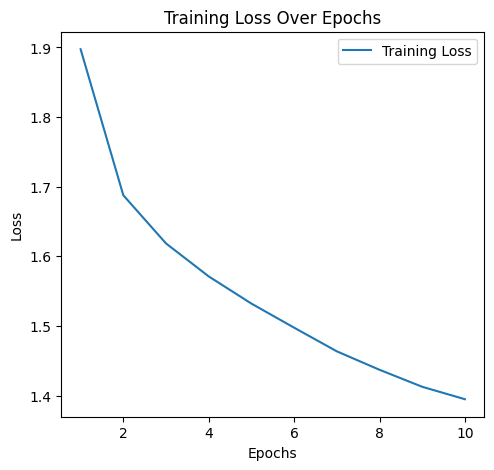

In [ ]:
'''
epochs = range(1, len(train_loss) + 1)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, label='Training Loss')
plt.title('Training Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

'''

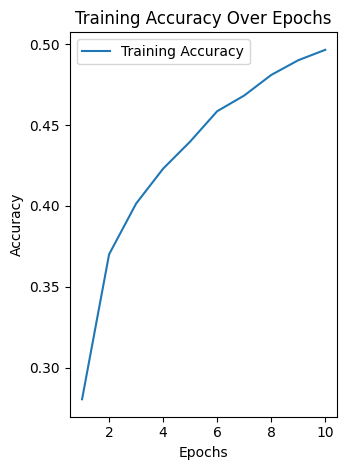

In [ ]:
'''
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracy, label='Training Accuracy')
plt.title('Training Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()
'''

Epoch 1/10
1563/1563 [==============================] - 25s 12ms/step - loss: 1.6044 - accuracy: 0.4113 - val_loss: 1.2659 - val_accuracy: 0.5460
Epoch 2/10
1563/1563 [==============================] - 15s 10ms/step - loss: 1.2980 - accuracy: 0.5348 - val_loss: 1.7693 - val_accuracy: 0.4290
Epoch 3/10
1563/1563 [==============================] - 15s 9ms/step - loss: 1.1777 - accuracy: 0.5813 - val_loss: 1.2123 - val_accuracy: 0.5591
Epoch 4/10
1563/1563 [==============================] - 18s 12ms/step - loss: 1.1023 - accuracy: 0.6097 - val_loss: 1.2435 - val_accuracy: 0.5505
Epoch 5/10
1563/1563 [==============================] - 22s 14ms/step - loss: 1.0516 - accuracy: 0.6320 - val_loss: 1.2510 - val_accuracy: 0.5617
Epoch 6/10
1563/1563 [==============================] - 15s 9ms/step - loss: 1.0003 - accuracy: 0.6474 - val_loss: 0.9214 - val_accuracy: 0.6740
Epoch 7/10
1563/1563 [==============================] - 15s 9ms/step - loss: 0.9664 - accuracy: 0.6651 - val_loss: 0.9430 - va

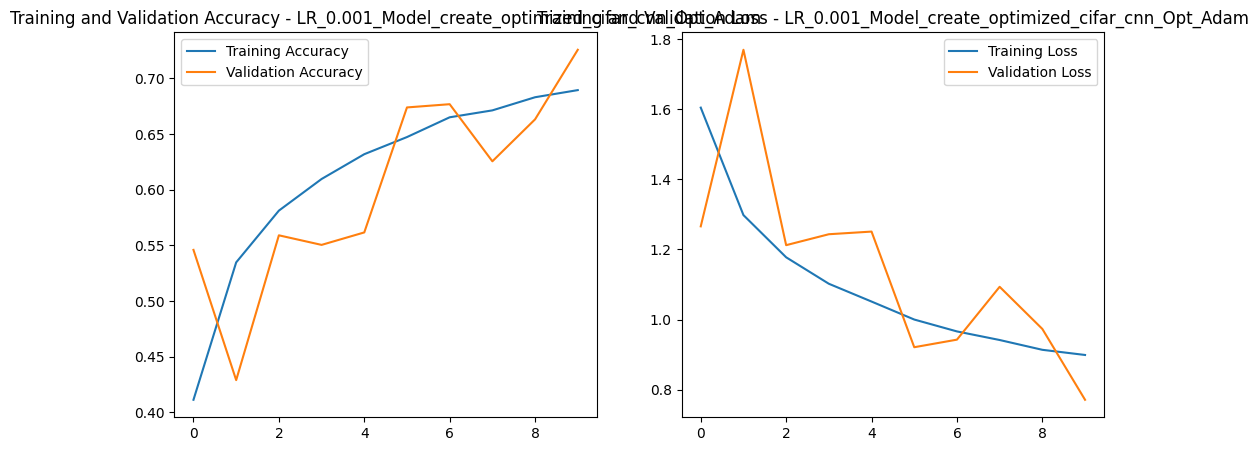

Test Loss: 0.7715534567832947, Test Accuracy: 0.7257999777793884
Epoch 1/10
1563/1563 [==============================] - 31s 18ms/step - loss: 2.1641 - accuracy: 0.2215 - val_loss: 1.9101 - val_accuracy: 0.3031
Epoch 2/10
1563/1563 [==============================] - 15s 9ms/step - loss: 1.9007 - accuracy: 0.2901 - val_loss: 1.7843 - val_accuracy: 0.3438
Epoch 3/10
1563/1563 [==============================] - 16s 10ms/step - loss: 1.8079 - accuracy: 0.3227 - val_loss: 1.8246 - val_accuracy: 0.3169
Epoch 4/10
1563/1563 [==============================] - 15s 9ms/step - loss: 1.7448 - accuracy: 0.3478 - val_loss: 1.6879 - val_accuracy: 0.3728
Epoch 5/10
1563/1563 [==============================] - 16s 10ms/step - loss: 1.6967 - accuracy: 0.3694 - val_loss: 1.5680 - val_accuracy: 0.4303
Epoch 6/10
1563/1563 [==============================] - 14s 9ms/step - loss: 1.6551 - accuracy: 0.3875 - val_loss: 1.6464 - val_accuracy: 0.3841
Epoch 7/10
1563/1563 [==============================] - 14s 9m

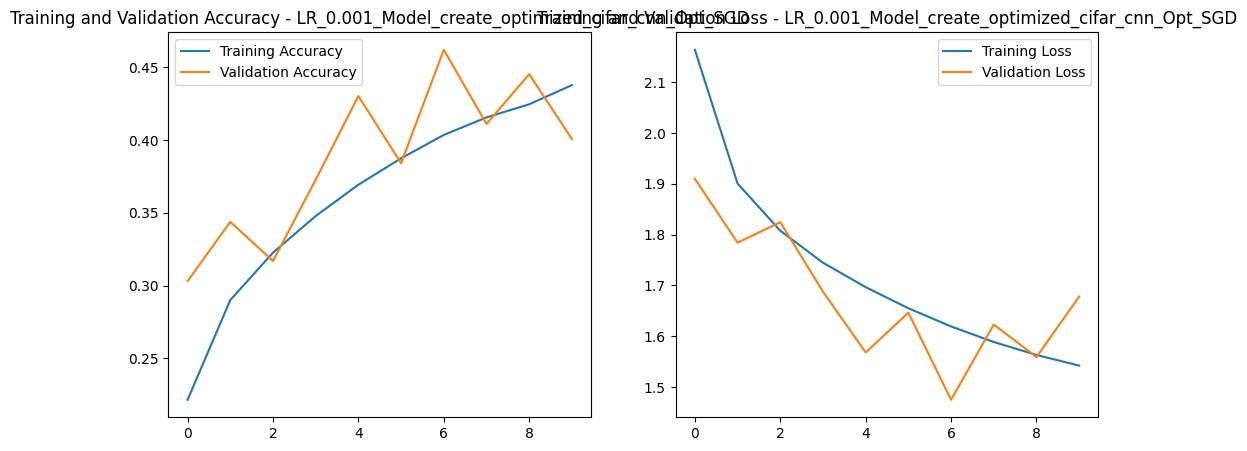

Test Loss: 1.678193211555481, Test Accuracy: 0.4007999897003174
Epoch 1/10
1563/1563 [==============================] - 23s 12ms/step - loss: 1.7398 - accuracy: 0.3583 - val_loss: 1.4261 - val_accuracy: 0.4641
Epoch 2/10
1563/1563 [==============================] - 14s 9ms/step - loss: 1.4709 - accuracy: 0.4653 - val_loss: 1.3076 - val_accuracy: 0.5187
Epoch 3/10
1563/1563 [==============================] - 14s 9ms/step - loss: 1.3677 - accuracy: 0.5058 - val_loss: 1.4058 - val_accuracy: 0.5000
Epoch 4/10
1563/1563 [==============================] - 15s 9ms/step - loss: 1.3056 - accuracy: 0.5366 - val_loss: 1.2083 - val_accuracy: 0.5521
Epoch 5/10
1563/1563 [==============================] - 14s 9ms/step - loss: 1.2689 - accuracy: 0.5461 - val_loss: 1.3299 - val_accuracy: 0.5282
Epoch 6/10
1563/1563 [==============================] - 14s 9ms/step - loss: 1.2351 - accuracy: 0.5641 - val_loss: 1.2028 - val_accuracy: 0.5604
Epoch 7/10
1563/1563 [==============================] - 14s 9ms/s

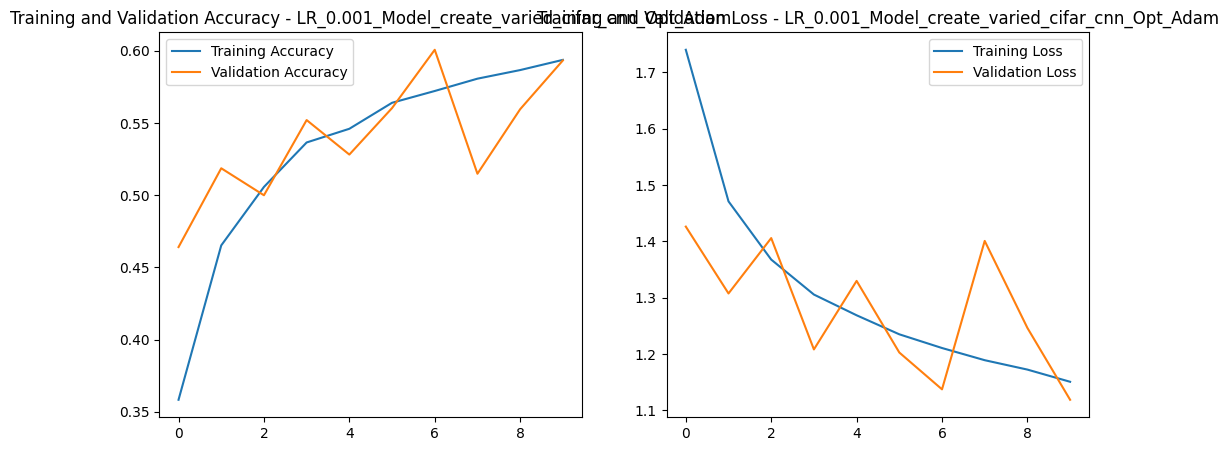

Test Loss: 1.119002103805542, Test Accuracy: 0.5934000015258789
Epoch 1/10
1563/1563 [==============================] - 21s 12ms/step - loss: 2.2466 - accuracy: 0.1800 - val_loss: 2.0189 - val_accuracy: 0.2707
Epoch 2/10
1563/1563 [==============================] - 14s 9ms/step - loss: 2.0439 - accuracy: 0.2430 - val_loss: 1.9387 - val_accuracy: 0.2895
Epoch 3/10
1563/1563 [==============================] - 14s 9ms/step - loss: 1.9554 - accuracy: 0.2752 - val_loss: 1.8226 - val_accuracy: 0.3260
Epoch 4/10
1563/1563 [==============================] - 14s 9ms/step - loss: 1.8971 - accuracy: 0.2884 - val_loss: 1.7973 - val_accuracy: 0.3516
Epoch 5/10
1563/1563 [==============================] - 14s 9ms/step - loss: 1.8547 - accuracy: 0.3056 - val_loss: 1.7316 - val_accuracy: 0.3510
Epoch 6/10
1563/1563 [==============================] - 14s 9ms/step - loss: 1.8252 - accuracy: 0.3163 - val_loss: 1.7181 - val_accuracy: 0.3656
Epoch 7/10
1563/1563 [==============================] - 14s 9ms/s

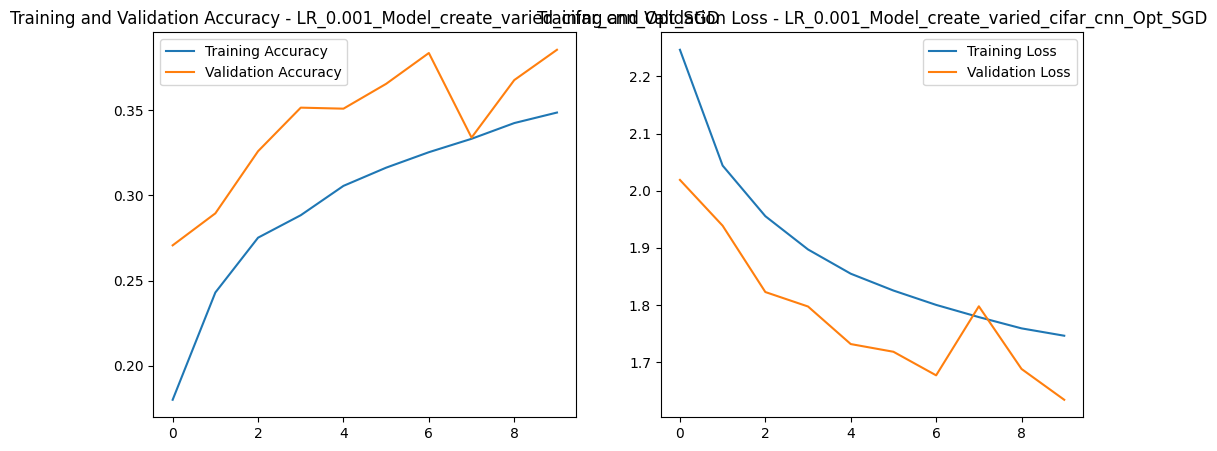

Test Loss: 1.634059190750122, Test Accuracy: 0.3856000006198883
Epoch 1/10
1563/1563 [==============================] - 24s 13ms/step - loss: 1.9172 - accuracy: 0.2962 - val_loss: 1.6129 - val_accuracy: 0.3930
Epoch 2/10
1563/1563 [==============================] - 15s 10ms/step - loss: 1.6336 - accuracy: 0.4009 - val_loss: 1.5489 - val_accuracy: 0.4446
Epoch 3/10
1563/1563 [==============================] - 15s 10ms/step - loss: 1.5009 - accuracy: 0.4532 - val_loss: 1.3527 - val_accuracy: 0.5004
Epoch 4/10
1563/1563 [==============================] - 15s 10ms/step - loss: 1.4139 - accuracy: 0.4876 - val_loss: 1.2362 - val_accuracy: 0.5504
Epoch 5/10
1563/1563 [==============================] - 17s 10ms/step - loss: 1.3469 - accuracy: 0.5141 - val_loss: 1.3803 - val_accuracy: 0.5049
Epoch 6/10
1563/1563 [==============================] - 15s 9ms/step - loss: 1.2994 - accuracy: 0.5318 - val_loss: 1.3186 - val_accuracy: 0.5268
Epoch 7/10
1563/1563 [==============================] - 16s 1

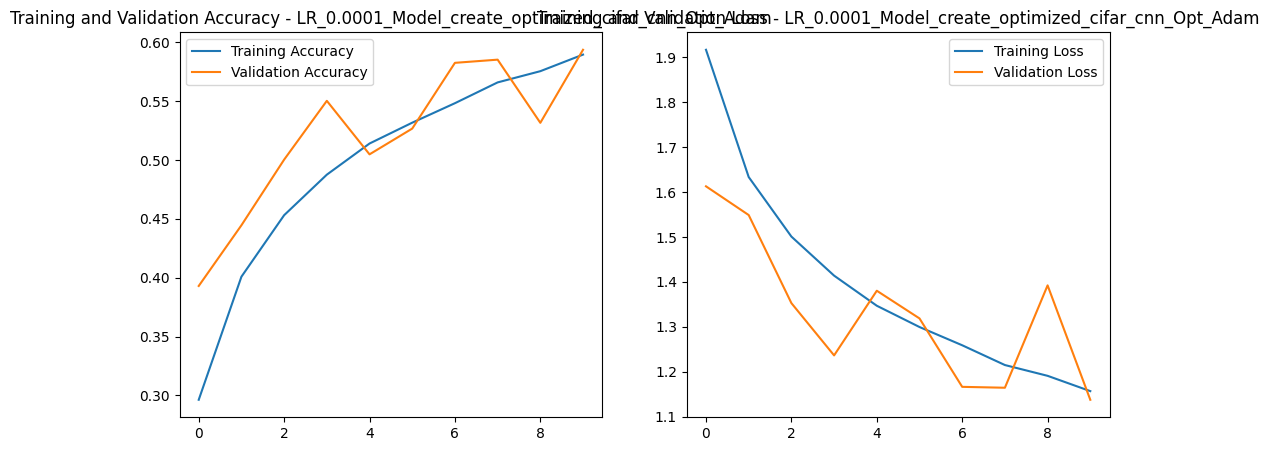

Test Loss: 1.1373414993286133, Test Accuracy: 0.5938000082969666
Epoch 1/10
1563/1563 [==============================] - 24s 13ms/step - loss: 2.5981 - accuracy: 0.1348 - val_loss: 2.1463 - val_accuracy: 0.2118
Epoch 2/10
1563/1563 [==============================] - 15s 10ms/step - loss: 2.3190 - accuracy: 0.1826 - val_loss: 2.0635 - val_accuracy: 0.2475
Epoch 3/10
1563/1563 [==============================] - 15s 9ms/step - loss: 2.2034 - accuracy: 0.2025 - val_loss: 2.0121 - val_accuracy: 0.2658
Epoch 4/10
1563/1563 [==============================] - 15s 9ms/step - loss: 2.1342 - accuracy: 0.2205 - val_loss: 1.9803 - val_accuracy: 0.2753
Epoch 5/10
1563/1563 [==============================] - 17s 10ms/step - loss: 2.0848 - accuracy: 0.2374 - val_loss: 1.9500 - val_accuracy: 0.2901
Epoch 6/10
1563/1563 [==============================] - 15s 9ms/step - loss: 2.0474 - accuracy: 0.2457 - val_loss: 1.9308 - val_accuracy: 0.2975
Epoch 7/10
1563/1563 [==============================] - 15s 10

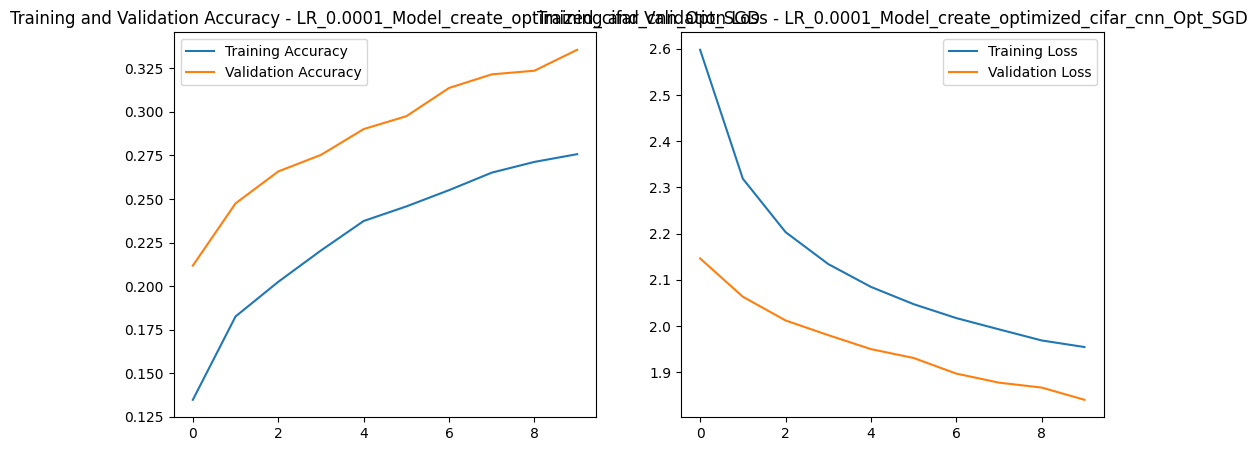

Test Loss: 1.8403486013412476, Test Accuracy: 0.33559998869895935
Epoch 1/10
1563/1563 [==============================] - 23s 12ms/step - loss: 2.0825 - accuracy: 0.2333 - val_loss: 1.8220 - val_accuracy: 0.3109
Epoch 2/10
1563/1563 [==============================] - 15s 9ms/step - loss: 1.8518 - accuracy: 0.3106 - val_loss: 1.6970 - val_accuracy: 0.3662
Epoch 3/10
1563/1563 [==============================] - 15s 9ms/step - loss: 1.7435 - accuracy: 0.3533 - val_loss: 1.5661 - val_accuracy: 0.4230
Epoch 4/10
1563/1563 [==============================] - 15s 9ms/step - loss: 1.6640 - accuracy: 0.3861 - val_loss: 1.4692 - val_accuracy: 0.4691
Epoch 5/10
1563/1563 [==============================] - 15s 9ms/step - loss: 1.6067 - accuracy: 0.4124 - val_loss: 1.3939 - val_accuracy: 0.4992
Epoch 6/10
1563/1563 [==============================] - 15s 9ms/step - loss: 1.5626 - accuracy: 0.4302 - val_loss: 1.3572 - val_accuracy: 0.5090
Epoch 7/10
1563/1563 [==============================] - 15s 9ms

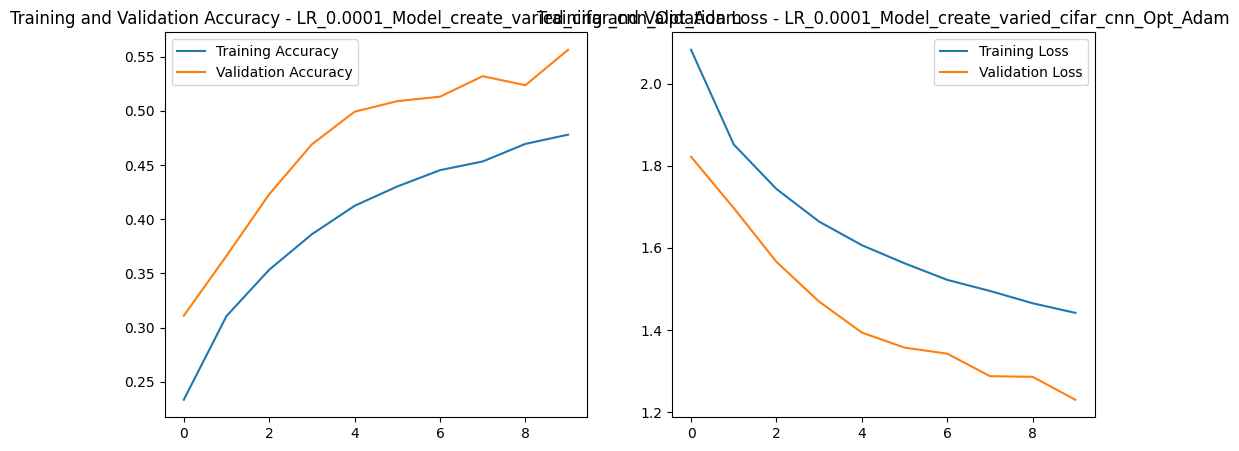

Test Loss: 1.2302266359329224, Test Accuracy: 0.5564000010490417
Epoch 1/10
1563/1563 [==============================] - 22s 13ms/step - loss: 2.5477 - accuracy: 0.1162 - val_loss: 2.2620 - val_accuracy: 0.1543
Epoch 2/10
1563/1563 [==============================] - 15s 9ms/step - loss: 2.3608 - accuracy: 0.1474 - val_loss: 2.1881 - val_accuracy: 0.1992
Epoch 3/10
1563/1563 [==============================] - 15s 9ms/step - loss: 2.2771 - accuracy: 0.1722 - val_loss: 2.1441 - val_accuracy: 0.2120
Epoch 4/10
1563/1563 [==============================] - 15s 9ms/step - loss: 2.2281 - accuracy: 0.1856 - val_loss: 2.1115 - val_accuracy: 0.2240
Epoch 5/10
1563/1563 [==============================] - 15s 9ms/step - loss: 2.1885 - accuracy: 0.1958 - val_loss: 2.0873 - val_accuracy: 0.2349
Epoch 6/10
1563/1563 [==============================] - 15s 9ms/step - loss: 2.1619 - accuracy: 0.2052 - val_loss: 2.0654 - val_accuracy: 0.2462
Epoch 7/10
1563/1563 [==============================] - 15s 9ms/

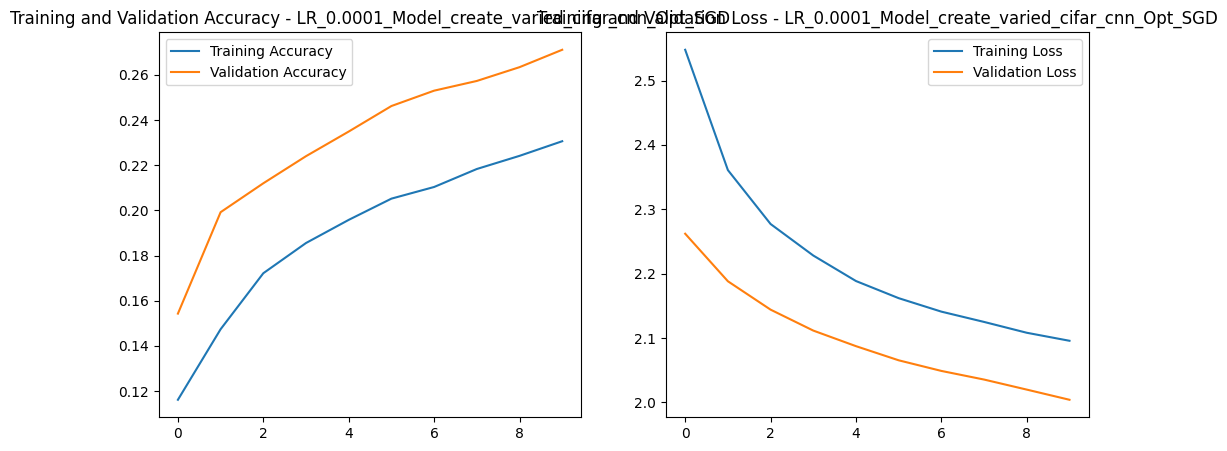

Test Loss: 2.0040533542633057, Test Accuracy: 0.2711000144481659


In [9]:
def load_and_prep_cifar(batch_size, shuffle_buffer_size):
    def preprocessing_func(img, label):
        img = tf.cast(img, tf.float32)
        img = (img / 255.0)  # Normalize between 0 and 1
        return img, label

    train = tfds.load('cifar10', split='train', as_supervised=True)
    test = tfds.load('cifar10', split='test', as_supervised=True)

    train = train.map(preprocessing_func, num_parallel_calls=tf.data.AUTOTUNE)
    test = test.map(preprocessing_func, num_parallel_calls=tf.data.AUTOTUNE)

    train = train.shuffle(shuffle_buffer_size).batch(batch_size).prefetch(tf.data.AUTOTUNE)
    test = test.batch(batch_size).prefetch(tf.data.AUTOTUNE)

    return train, test


def create_optimized_cifar_cnn(name='optimized_cnn', num_filters=[32, 64, 128], kernel_size=3, dense_units=128):
    inputs = tf.keras.Input(shape=(32, 32, 3), dtype=tf.float32)

    x = inputs
    for filters in num_filters:
        x = tf.keras.layers.Conv2D(filters=filters, kernel_size=kernel_size, activation='relu', padding='same')(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
        x = tf.keras.layers.Dropout(0.25)(x)

    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dense(dense_units, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    x = tf.keras.layers.Dense(10, activation='softmax')(x)  # CIFAR-10 has 10 classes

    model = tf.keras.Model(inputs, x, name=name)
    return model


def create_varied_cifar_cnn(name='varied_cnn', num_filters=[16, 32, 64], kernel_size=3, dense_units=64):
    inputs = tf.keras.Input(shape=(32, 32, 3), dtype=tf.float32)

    x = inputs
    for filters in num_filters:
        x = tf.keras.layers.Conv2D(filters=filters, kernel_size=kernel_size, activation='relu', padding='same')(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
        x = tf.keras.layers.Dropout(0.25)(x)

    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dense(dense_units, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    x = tf.keras.layers.Dense(10, activation='softmax')(x)

    model = tf.keras.Model(inputs, x, name=name)
    return model



def train(model_fn, optimizer, num_epochs, batch_size, shuffle_buffer_size, lr):
    model = model_fn()
    model.compile(optimizer=optimizer(lr), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    train_dataset, test_dataset = load_and_prep_cifar(batch_size, shuffle_buffer_size)
    history = model.fit(train_dataset, epochs=num_epochs, validation_data=test_dataset)
    return model, history, test_dataset

def evaluate(model, test_dataset):
    test_loss, test_accuracy = model.evaluate(test_dataset)
    return test_loss, test_accuracy


def visualize_performance(history, test_loss, test_accuracy, config_name):
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'Training and Validation Accuracy - {config_name}')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'Training and Validation Loss - {config_name}')
    plt.legend()

    plt.show()
    print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")


learning_rates = [0.001, 0.0001]
model_functions = [create_optimized_cifar_cnn, create_varied_cifar_cnn]
optimizers = [tf.keras.optimizers.Adam, tf.keras.optimizers.SGD]

for lr in learning_rates:
    for model_fn in model_functions:
        for opt in optimizers:
            model, history, test_dataset = train(model_fn, opt, 10, 32, 10000, lr)
            test_loss, test_accuracy = evaluate(model, test_dataset)
            config_name = f"LR_{lr}_Model_{model_fn.__name__}_Opt_{opt.__name__}"
            visualize_performance(history, test_loss, test_accuracy, config_name)


In [ ]:
# without model.fit

def load_and_prep_cifar(batch_size, shuffle_buffer_size):
    def preprocessing_func(img, label):
        img = tf.cast(img, tf.float32)
        img = (img / 255.0)  # Normalize between 0 and 1
        return img, label

    train = tfds.load('cifar10', split='train', as_supervised=True)
    test = tfds.load('cifar10', split='test', as_supervised=True)

    train = train.map(preprocessing_func, num_parallel_calls=tf.data.AUTOTUNE)
    test = test.map(preprocessing_func, num_parallel_calls=tf.data.AUTOTUNE)

    train = train.shuffle(shuffle_buffer_size).batch(batch_size).prefetch(tf.data.AUTOTUNE)
    test = test.batch(batch_size).prefetch(tf.data.AUTOTUNE)

    return train, test


def create_optimized_cifar_cnn(name='optimized_cnn', num_filters=[32, 64, 128], kernel_size=3, dense_units=128):
    inputs = tf.keras.Input(shape=(32, 32, 3), dtype=tf.float32)

    x = inputs
    for filters in num_filters:
        x = tf.keras.layers.Conv2D(filters=filters, kernel_size=kernel_size, activation='relu', padding='same')(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
        x = tf.keras.layers.Dropout(0.25)(x)

    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dense(dense_units, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    x = tf.keras.layers.Dense(10, activation='softmax')(x)  # CIFAR-10 has 10 classes

    model = tf.keras.Model(inputs, x, name=name)
    return model


def create_varied_cifar_cnn(name='varied_cnn', num_filters=[16, 32, 64], kernel_size=3, dense_units=64):
    inputs = tf.keras.Input(shape=(32, 32, 3), dtype=tf.float32)

    x = inputs
    for filters in num_filters:
        x = tf.keras.layers.Conv2D(filters=filters, kernel_size=kernel_size, activation='relu', padding='same')(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
        x = tf.keras.layers.Dropout(0.25)(x)

    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dense(dense_units, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    x = tf.keras.layers.Dense(10, activation='softmax')(x)

    model = tf.keras.Model(inputs, x, name=name)
    return model



def train_custom_loop(model_fn, optimizer_fn, num_epochs, batch_size, shuffle_buffer_size, lr):
    model = model_fn()
    optimizer = optimizer_fn(lr)
    loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
    train_dataset, test_dataset = load_and_prep_cifar(batch_size, shuffle_buffer_size)

    for epoch in range(num_epochs):
        epoch_loss_avg = tf.keras.metrics.Mean()
        epoch_accuracy = tf.keras.metrics.SparseCategoricalAccuracy()

        # Training loop
        for x, y in train_dataset:
            with tf.GradientTape() as tape:
                predictions = model(x, training=True)
                loss = loss_fn(y, predictions)
            gradients = tape.gradient(loss, model.trainable_variables)
            optimizer.apply_gradients(zip(gradients, model.trainable_variables))
            epoch_loss_avg.update_state(loss)
            epoch_accuracy.update_state(y, predictions)

        # Validation loop
        val_loss = tf.keras.metrics.Mean()
        val_accuracy = tf.keras.metrics.SparseCategoricalAccuracy()
        for x_val, y_val in test_dataset:
            val_predictions = model(x_val, training=False)
            v_loss = loss_fn(y_val, val_predictions)
            val_loss.update_state(v_loss)
            val_accuracy.update_state(y_val, val_predictions)

        print(f"Epoch {epoch+1}/{num_epochs}")
        print(f"1563/1563 [==============================] - loss: {epoch_loss_avg.result()} - accuracy: {epoch_accuracy.result()} - val_loss: {val_loss.result()} - val_accuracy: {val_accuracy.result()}")

    return model, epoch_loss_avg, epoch_accuracy, val_loss, val_accuracy



def evaluate(model, test_dataset):
    test_loss, test_accuracy = model.evaluate(test_dataset)
    return test_loss, test_accuracy



def visualize_performance(train_loss, train_accuracy, test_loss, test_accuracy, config_name):
    epochs_range = range(len(train_loss))

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, train_accuracy, label='Training Accuracy')
    plt.title(f'Training Accuracy - {config_name}')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, train_loss, label='Training Loss')
    plt.title(f'Training Loss - {config_name}')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()
    print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")


learning_rates = [0.001, 0.0001]
model_functions = [create_optimized_cifar_cnn, create_varied_cifar_cnn]
optimizers = [tf.keras.optimizers.Adam, tf.keras.optimizers.SGD]

for lr in learning_rates:
    for model_fn in model_functions:
        for opt in optimizers:
            model, train_loss, train_accuracy, test_dataset = train_custom_loop(model_fn, opt, NUM_EPOCHS, BATCH_SIZE, SHUFFLE_BUFFER_SIZE, lr)
            test_loss, test_accuracy = evaluate(model, test_dataset)
            config_name = f"LR_{lr}_Model_{model_fn.__name__}_Opt_{opt.__name__}"
            visualize_performance({"accuracy": train_accuracy, "loss": train_loss}, test_loss, test_accuracy, config_name)


